In [154]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from itertools import product
from scipy.stats import qmc  # For Latin Hypercube Sampling
import torch
import gpytorch
import random
from PIL import Image
from datetime import datetime

In [155]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, meanPrior):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        if meanPrior == 'max':
            # self.mean_module = gpytorch.means.ZeroMean()
            self.mean_module = gpytorch.means.ConstantMean()
            # self.mean_module.constant = torch.nn.Parameter(torch.tensor(torch.max(train_y)))
            self.mean_module.constant.data = torch.tensor(torch.max(train_y))

        else:
            # self.mean_module = gpytorch.means.ConstantMean(constant_prior=torch.max(train_y))
            self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
def GPTrain(features, targets, meanPrior):

    tensorSamplesXY = torch.from_numpy(features)
    tensorSamplesZ = torch.from_numpy(targets)

    likelihood = gpytorch.likelihoods.GaussianLikelihood() 
    model = ExactGPModel(tensorSamplesXY, tensorSamplesZ, likelihood, meanPrior)
    likelihood.noise = 1e-4
    likelihood.noise_covar.raw_noise.requires_grad_(False)

    training_iter = 250
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(tensorSamplesXY)
        # Calc loss and backprop gradients
        loss = -mll(output, tensorSamplesZ)
        loss.backward()
        # print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        #     i + 1, training_iter, loss.item(),
        #     model.covar_module.base_kernel.lengthscale.item(), #.kernels[0] after base_kernel if have multiple kernels
        #     model.likelihood.noise.item()
        # ))
        optimizer.step()
    
    return model


def GPEval(model, newFeatures):
    model.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = model(torch.from_numpy(newFeatures))

    mean_pred = observed_pred.mean.numpy()

    return mean_pred

In [156]:
class DifferentialEvolution:
    def __init__(self, bounds, objective_function, pop_size=50, mutation_factor=0.8, crossover_prob=0.7, max_generations=200, method='random'):
        """
        Initialize the Differential Evolution (DE) optimizer.
        
        Parameters:
        bounds (list of tuple): List of (min, max) bounds for each dimension.
        pop_size (int): Number of candidate solutions in the population.
        mutation_factor (float): Scaling factor for mutation [0, 2].
        crossover_prob (float): Crossover probability [0, 1].
        max_generations (int): Maximum number of generations to evolve.
        method (str): Population initialization method ('random' or 'lhs').
        """
        self.bounds = np.array(bounds)
        self.dimensions = len(bounds)
        self.pop_size = pop_size
        self.mutation_factor = mutation_factor
        self.crossover_prob = crossover_prob
        self.max_generations = max_generations
        self.method = method
        
        # Initialize population
        self.population = self.initialize_population()
        self.best_solution = None
        self.best_fitness = np.inf
        self.objective_function = objective_function
    
    def initialize_population(self):
        """Initialize population using random sampling or Latin Hypercube Sampling."""
        if self.method == 'lhs':
            # Latin Hypercube Sampling
            sampler = qmc.LatinHypercube(d=self.dimensions)
            sample = sampler.random(n=self.pop_size)
            population = qmc.scale(sample, self.bounds[:, 0], self.bounds[:, 1])
        else:
            # Random Sampling
            population = np.random.rand(self.pop_size, self.dimensions)
            for i in range(self.dimensions):
                population[:, i] = self.bounds[i, 0] + population[:, i] * (self.bounds[i, 1] - self.bounds[i, 0])
        
        # print(population.shape)
        return population
    
    def mutate(self, target_idx):
        """Mutation using DE/best/1 strategy."""
        # Choose three random and distinct individuals different from target_idx
        indices = [idx for idx in range(self.pop_size) if idx != target_idx]
        np.random.shuffle(indices)
        r1, r2 , r3= indices[:3]
        
        # Best individual in current population

        # print(self.population.shape)

        #TODO  instead of this list comprehension bollocks just evaluate them all at once
        #as thats what i think it wants, then find the minimum of the results. 


        predictedValues = GPEval(self.objective_function, self.population)

        best_idx = np.argsort(predictedValues)[:1]

        best = self.population[best_idx]

        # best_idx = np.argmin([self.objective_function.predict(ind) for ind in self.population])
        # best = self.population[best_idx]
        
        # Mutant vector: v = best + F * (r1 - r2)
        mutant = best + self.mutation_factor * (self.population[r1] - self.population[r2])
        
        # Ensure mutant vector is within bounds
        mutant = np.clip(mutant, self.bounds[:, 0], self.bounds[:, 1])
        
        return mutant
    
    def crossover(self, target, mutant):
        """Crossover to create trial vector."""
        trial = np.copy(target)
        # print(trial.shape)
        # print(mutant.shape)
        for i in range(self.dimensions):
            if np.random.rand() < self.crossover_prob or i == np.random.randint(self.dimensions):
                # print(trial[i], mutant[i])
                trial[i] = mutant[i]
        return trial
    
    def select(self, target, trial):
        """Selection: Return the individual with the better fitness."""
        if self.objective_function.predict(trial) < self.objective_function.predict(target):
            return trial
        return target

    def select(self, target, trial):
        """Selection: Return the individual with the better fitness."""
        if GPEval(self.objective_function, trial) < GPEval(self.objective_function, target):
            return trial
        return target
    
    def optimize(self):
        """Run the Differential Evolution optimization."""
        # x_range = np.linspace(-5, 5, 100)
        # y_range = np.linspace(-5, 5, 100)
        # X, Y = np.meshgrid(x_range, y_range)
        # Z = ackley_function(X, Y)
        x_range = np.linspace(self.bounds[0,0], self.bounds[0,1],50)
        y_range = np.linspace(self.bounds[1,0], self.bounds[1,1],50)
        fullRange = list(product(x_range, y_range))
        fullRangeArray = np.array(fullRange)
        # y_pred = self.objective_function.predict(fullRangeArray)
        y_pred = GPEval(self.objective_function, fullRangeArray)

        for generation in range(self.max_generations):
            new_population = np.zeros_like(self.population)
            allTrials = np.zeros_like(self.population)
            allTargets = np.zeros_like(self.population)
            # print(self.population.shape)
            for i in range(self.pop_size):
                target = self.population[i]
                # print('break')
                # print(i)
                mutant = self.mutate(i)
                # print(mutant)
                mutant = np.reshape(mutant, (2,))
                # print(mutant)
                trial = self.crossover(target, mutant)
                trial = np.reshape(trial, (1,-1))
                target = np.reshape(target, (1,-1))
                # print('for select', trial.shape, target.shape)
                new_population[i] = self.select(target, trial)
            
            # Update the population
            self.population = new_population
            
            # Track the best solution
            # best_idx = np.argmin([self.objective_function.predict(ind) for ind in self.population])
            # best_fitness = self.objective_function.predict(self.population[best_idx])
            
            # predictedValues = self.objective_function.predict(self.population)
            predictedValues = GPEval(self.objective_function, self.population)

            best_idx = np.argsort(predictedValues)[:1]

            # best_fitness = self.objective_function.predict(self.population[best_idx])
            best_fitness = GPEval(self.objective_function, self.population[best_idx])

            if best_fitness < self.best_fitness:
                self.best_fitness = best_fitness
                self.best_solution = self.population[best_idx]
            
            # plt.contourf(x_range, y_range, y_pred, levels=50, cmap='viridis')
        plt.scatter(fullRangeArray[:,0], fullRangeArray[:,1], c = y_pred)

        plt.scatter(self.population[:, 0], self.population[:, 1], color='red', label='Final Population', s=5)
        # plt.scatter(best_solution[0], best_solution[1], color='blue', label='Best Solution', s=100)
        # plt.legend()
        plt.title("Local Surrogate")
        plt.colorbar()
        plt.clim(0,14)
        plt.xlim(self.bounds[0,0], self.bounds[0,1])
        plt.ylim(self.bounds[1,0], self.bounds[1,1])
        # plt.savefig('localGP.png')
        plt.show()
        # # Debug information
        print(f"Generation {generation + 1}: Best RBF Fitness = {self.best_fitness}")
        
        return self.best_solution, self.best_fitness

In [157]:
# Objective function (Ackley function used as an example)
def ackley_function(x, y, a=20, b=0.2, c=2 * np.pi):
    term1 = -a * np.exp(-b * np.sqrt(0.5 * (x**2 + y**2)))
    term2 = -np.exp(0.5 * (np.cos(c * x) + np.cos(c * y)))
    return term1 + term2 + a + np.exp(1)

# Objective function (Ackley function used as an example)
# def ackley_function(x, y, a=20, b=0.2, c=2 * np.pi):
#     z = np.sin(x)+(x*np.cos(0.5*y))
#     return z

def objective_function(vec):
    """Objective function wrapper for optimization.
    Args:
        vec (np.ndarray): A vector representing candidate solution (x, y).
    Returns:
        float: Fitness value of the solution.
    """
    x, y = vec
    return ackley_function(x, y)

In [158]:
class fullCrossover:
    def __init__(self, bounds, pop_size, localPopSize):
        self.globalBounds = np.array(bounds)
        self.dimensions = len(bounds)
        self.pop_size = pop_size
        self.feFeatures = np.empty((0,2))
        self.feTargets = np.empty(0) 
        # self.k = k
        self.population = self.initialiseDatabase()
        self.localPopSize = localPopSize

    def initialiseDatabase(self):

        sampler = qmc.LatinHypercube(d=self.dimensions)
        sample = sampler.random(n=self.pop_size)
        population = qmc.scale(sample, self.globalBounds[:, 0], self.globalBounds[:, 1])

        for i in range(0, len(population)):
            self.feTargets = np.append(self.feTargets, objective_function(population[i]))
            self.feFeatures = np.vstack((self.feFeatures, population[i]))

        plt.scatter(self.feFeatures[:,0], self.feFeatures[:,1], c = self.feTargets)
        plt.title('Initial Population')
        plt.colorbar()
        plt.show()

        return population
    
    def crossover(self):

        #build surrogate using all points in population
        crossoverGP = GPTrain(self.feFeatures, self.feTargets, meanPrior='zero')

        best_idx = np.argmin(self.feTargets)
        bestFeature = self.feFeatures[best_idx]
        bestTarget = self.feTargets[best_idx]

        RVS = random.sample(range(0, self.dimensions), self.dimensions)

        print(self.feFeatures.shape)
        print(bestFeature)

        x_range = np.linspace(self.globalBounds[0,0], self.globalBounds[0,1],100)
        y_range = np.linspace(self.globalBounds[1,0], self.globalBounds[1,1],100)
        fullRange = list(product(x_range, y_range))
        fullRangeArray = np.array(fullRange)
        # y_pred = self.objective_function.predict(fullRangeArray)
        y_pred = GPEval(crossoverGP, fullRangeArray)

        tempPop = np.full_like((self.feFeatures), bestFeature)

        # print(tempPop)

        for i in RVS:
            # print(i)

            tempPop[:,i] = self.feFeatures[:,i]

            tempPopEval = GPEval(crossoverGP, tempPop)

            plt.scatter(fullRangeArray[:,0], fullRangeArray[:,1], c = y_pred, alpha = 0.5)
            plt.scatter(tempPop[:, 0], tempPop[:, 1], color='red', label='crossover', s=10, marker='x')
            plt.scatter(bestFeature[0], bestFeature[1], color='blue', label='Best Solution', s=10)
            plt.legend()
            plt.title("Full-Crossover")
            plt.colorbar()
            plt.clim(0, 14)
            # plt.savefig(f'DEPlots/{generation}.png')
            plt.show()

            tempPopBestIdx = np.argmin(tempPopEval)
            if tempPopEval[tempPopBestIdx] > bestTarget:
                tempPop = np.full_like((self.feFeatures), tempPop[tempPopBestIdx])
                print('new best value!')

            

        #take final best predicted value and explicitely evaluate
        self.feTargets = np.append(self.feTargets, objective_function(tempPop[tempPopBestIdx]))
        self.feFeatures = np.vstack((self.feFeatures, tempPop[tempPopBestIdx]))





        plt.scatter(self.feFeatures[:,0], self.feFeatures[:,1], c = self.feTargets)
        plt.scatter(self.feFeatures[-1,0], self.feFeatures[-1,1])
        plt.title('Population after 1 Iteration')
        plt.colorbar()
        plt.clim(0,14)
        plt.show()




            # print(tempPop.shape)



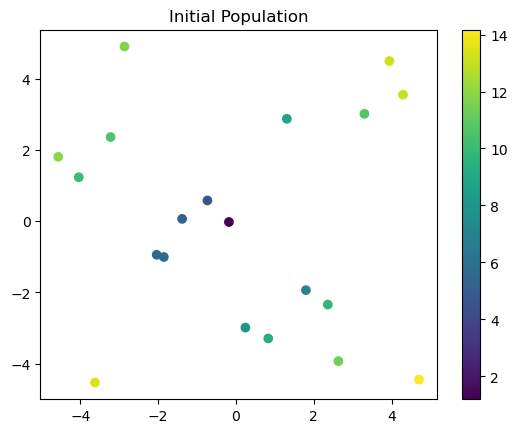

(20, 2)
[-0.17990377 -0.02361226]


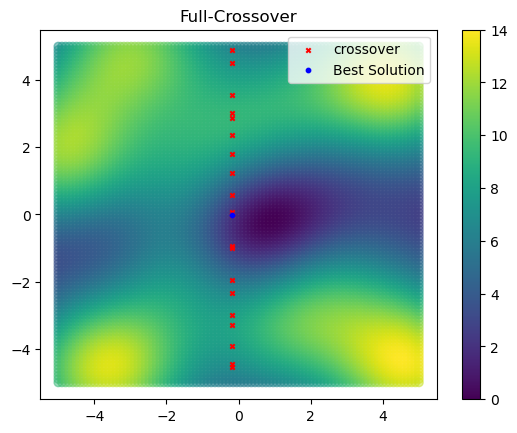

new best value!


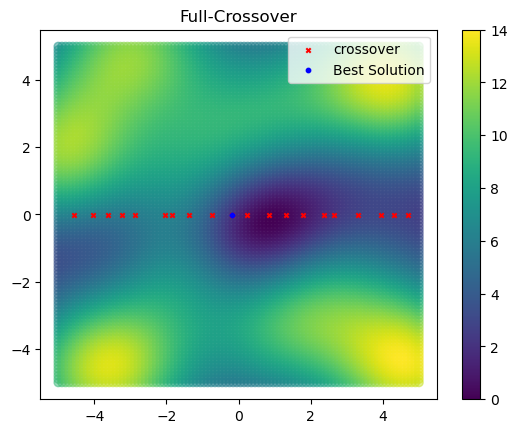

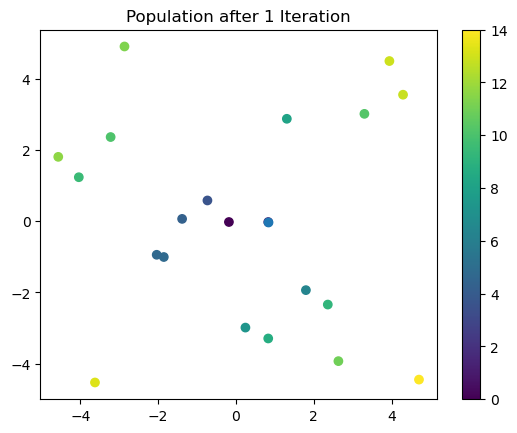

In [159]:
bounds = [(-5,5), (-5,5)] #bounds for each dimension (x and y)

fc = fullCrossover(bounds, 20, 25)

fc.crossover()

In [160]:
random_sequence = random.sample(range(1, 2 + 1), 2)

print(random_sequence)

[1, 2]
